# DBA3803 Group Project Predictive Analytics

In [1]:
# Import essential data science packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Import scikit-learn machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

# Import other necessary modules and pacakges from scikit-learn
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, TunedThresholdClassifierCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer

## Read in data and view information

In [2]:
df = pd.read_csv("final_churn_data.csv")
df.head()

,geography,gender,has_credit_card,is_active,card_type,age_group,age,credit_score,tenure,balance,num_products,est_salary,satisfaction_score,pts_earned,churned
0,France,Female,1,1,DIAMOND,Middle-Aged (26-45),42,619,2,0.00,1,101348.88,2,464,1
1,Spain,Female,0,1,DIAMOND,Middle-Aged (26-45),41,608,1,83807.86,1,112542.58,3,456,0
2,France,Female,1,0,DIAMOND,Middle-Aged (26-45),42,502,8,159660.80,3,113931.57,3,377,1
3,France,Female,0,0,GOLD,Middle-Aged (26-45),39,699,1,0.00,2,93826.63,5,350,0
4,Spain,Female,1,1,GOLD,Middle-Aged (26-45),43,850,2,125510.82,1,79084.10,5,425,0


There will be 2 approaches to applying predictive analytics methods to the data.

1. Using `age` only as a numeric variable, dropping the categorical `age group`
2. Using `age_group` only (created from the EDA), dropping the numeric variable `age`

No other features would be added/discarded. However, in both these approaches, certain columns would be one-hot encoded, ordinal encoded and scaled with `StandardScaler` to ensure cosnistency across all models.

## Approach 1: Only use `age` as a numeric variable

In [3]:
# Choose to use age as a numeric variable and drop the categorical age group
df1 = df.drop("age_group", axis = 1)
df1.head()

,geography,gender,has_credit_card,is_active,card_type,age,credit_score,tenure,balance,num_products,est_salary,satisfaction_score,pts_earned,churned
0,France,Female,1,1,DIAMOND,42,619,2,0.00,1,101348.88,2,464,1
1,Spain,Female,0,1,DIAMOND,41,608,1,83807.86,1,112542.58,3,456,0
2,France,Female,1,0,DIAMOND,42,502,8,159660.80,3,113931.57,3,377,1
3,France,Female,0,0,GOLD,39,699,1,0.00,2,93826.63,5,350,0
4,Spain,Female,1,1,GOLD,43,850,2,125510.82,1,79084.10,5,425,0


### Transform and fit data to model

In [4]:
# Define target column "churned"
y = df1["churned"]

# Define feature matrix X (all columns except "churned")
X = df1.drop(columns = ["churned"])

# Call train-test split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Define the categorical columns to one-hot encode
one_hot_encoded_cols = ["geography", "gender", "num_products"]
ord_encoded_cols = ["card_type"]

# Define the numeric columns to scale
numeric_cols = ["age", "credit_score", "tenure", "balance", "est_salary", "satisfaction_score", "pts_earned"]

# Create a column transformer to handle both the encoding and scaling
ct = make_column_transformer(
    (OneHotEncoder(drop = "first", sparse_output = False), one_hot_encoded_cols), # One-hot encoded categorical columns
    (OrdinalEncoder(categories = [["SILVER", "GOLD", "PLATINUM", "DIAMOND"]]), ord_encoded_cols),  # Ordinal encoded categorical columns
    (StandardScaler(), numeric_cols), # Scale numeric columns
    remainder = "passthrough" # Keep columns not transformed (e.g., "has_credit_card" and "is_active")
)

# Change output to pandas dataframe for easier readability
ct.set_output(transform = "pandas")

# Fit the column transformer on the training data and transform it
X_train_scaled = ct.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = ct.transform(X_test)

In [5]:
X_train_scaled

,onehotencoder__geography_Germany,onehotencoder__geography_Spain,onehotencoder__gender_Male,onehotencoder__num_products_2,onehotencoder__num_products_3,onehotencoder__num_products_4,ordinalencoder__card_type,standardscaler__age,standardscaler__credit_score,standardscaler__tenure,standardscaler__balance,standardscaler__est_salary,standardscaler__satisfaction_score,standardscaler__pts_earned,remainder__has_credit_card,remainder__is_active
9254,0.0,0.0,1.0,1.0,0.0,0.0,3.0,-0.655786,0.356500,0.345680,-1.218471,1.367670,-0.720010,-0.430193,1,1
1561,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.294938,-0.203898,-0.348369,0.696838,1.661254,0.704342,1.565908,1,1
1670,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.416365,-0.961472,-0.695393,0.618629,-0.252807,0.704342,-1.243749,1,0
6087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.131148,-0.940717,1.386753,0.953212,0.915393,-0.720010,-0.176791,1,0
6669,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.625953,-1.397337,1.386753,1.057449,-1.059600,-0.007834,0.534515,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.435808,1.207474,1.039728,-0.102301,-0.539860,-0.007834,-0.167899,1,1
5191,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.816097,0.314989,-1.389442,-1.218471,-1.733882,0.704342,0.454493,1,1
5390,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.085351,0.865009,-1.389442,-1.218471,-0.142765,1.416518,0.316678,0,0
860,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.390011,0.159323,1.039728,1.827259,-0.050826,-0.007834,0.325569,1,0


In [6]:
X_test_scaled

,onehotencoder__geography_Germany,onehotencoder__geography_Spain,onehotencoder__gender_Male,onehotencoder__num_products_2,onehotencoder__num_products_3,onehotencoder__num_products_4,ordinalencoder__card_type,standardscaler__age,standardscaler__credit_score,standardscaler__tenure,standardscaler__balance,standardscaler__est_salary,standardscaler__satisfaction_score,standardscaler__pts_earned,remainder__has_credit_card,remainder__is_active
6252,1.0,0.0,1.0,1.0,0.0,0.0,1.0,-0.655786,-0.577496,-0.695393,0.329937,-1.019605,-1.432186,0.454493,0,0
4684,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.390011,-0.297297,-1.389442,-1.218471,0.798883,-0.720010,-0.439084,1,1
1731,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.485083,-0.525607,-0.348369,-1.218471,-0.727980,-1.432186,-1.448249,1,0
4742,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.911170,-1.511492,1.039728,0.689272,1.221387,-0.720010,1.654821,1,1
4521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.131148,-0.951094,0.692704,0.782839,0.247560,1.416518,-0.665813,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.340735,-0.515230,-0.001345,0.354911,-0.963100,1.416518,0.916842,0,1
8285,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-1.321293,-0.442586,1.733777,-1.218471,0.164545,-0.720010,0.201091,0,1
7853,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.770301,0.813120,0.692704,-1.218471,-1.165916,-0.720010,-0.456867,1,0
1095,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.941003,0.418766,-0.348369,-1.218471,-0.411635,-0.007834,0.352243,1,0


In [7]:
y_train

9254    0
1561    0
1670    1
6087    1
6669    1
       ..
5734    0
5191    0
5390    1
860     1
7270    0
Name: churned, Length: 8000, dtype: int64

In [8]:
y_test

6252    0
4684    0
1731    0
4742    0
4521    0
       ..
6412    1
8285    0
7853    1
1095    1
6929    1
Name: churned, Length: 2000, dtype: int64

### Sample Approach: K-Nearest Neighbors Classifier

In [9]:
mod = GridSearchCV(estimator = KNeighborsClassifier(),
                   param_grid = {
                       "n_neighbors": np.arange(2, 11, 1),
                       "weights": ["uniform", "distance"],
                       "metric": ["euclidean", "manhattan"]
                    },
                    scoring = {"accuracy": make_scorer(accuracy_score), "f1_score": make_scorer(f1_score), "roc_auc_score": make_scorer(roc_auc_score)},
                    refit = "roc_auc_score",
                    cv = 5,
                    n_jobs = -1)

mod.fit(X_train_scaled, y_train)
gs_df = pd.DataFrame(mod.cv_results_)
gs_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_accuracy,split1_test_accuracy,...,std_test_f1_score,rank_test_f1_score,split0_test_roc_auc_score,split1_test_roc_auc_score,split2_test_roc_auc_score,split3_test_roc_auc_score,split4_test_roc_auc_score,mean_test_roc_auc_score,std_test_roc_auc_score,rank_test_roc_auc_score
0,0.013490,0.001278,0.612892,0.025443,euclidean,2,uniform,"{'metric': 'euclidean', 'n_neighbors': 2, 'wei...",0.808125,0.795625,...,0.039966,36,0.566099,0.544715,0.590308,0.568083,0.563346,0.566510,0.014519,36
1,0.014494,0.003398,0.316068,0.112136,euclidean,2,distance,"{'metric': 'euclidean', 'n_neighbors': 2, 'wei...",0.769375,0.760625,...,0.035040,10,0.620555,0.593646,0.654043,0.626704,0.607664,0.620522,0.020246,12
2,0.010576,0.000816,0.427492,0.010199,euclidean,3,uniform,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.810000,0.795625,...,0.026347,6,0.630356,0.605539,0.641388,0.625188,0.610831,0.622660,0.013034,6
3,0.012195,0.001210,0.198253,0.012487,euclidean,3,distance,"{'metric': 'euclidean', 'n_neighbors': 3, 'wei...",0.810000,0.795000,...,0.027412,5,0.630356,0.605145,0.642514,0.625188,0.610044,0.622650,0.013607,7
4,0.013149,0.003469,0.458352,0.036955,euclidean,4,uniform,"{'metric': 'euclidean', 'n_neighbors': 4, 'wei...",0.812500,0.800625,...,0.043798,34,0.578990,0.550115,0.599873,0.568584,0.569425,0.573397,0.016207,34


In [10]:
best_model = mod.best_estimator_
print(f"Best model (Highest ROC AUC Score): {best_model}")

y_pred = best_model.predict(X_test_scaled)

test_roc_auc, test_f1_score, test_acc_score = roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

print(f"Test ROC AUC Score: {round(test_roc_auc, 4)}")
print(f"Test F1 Score: {round(test_f1_score, 4)}")
print(f"Test Accuracy Score: {round(test_acc_score, 4)}")

Best model (Highest ROC AUC Score): KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
Test ROC AUC Score: 0.6609
Test F1 Score: 0.47
Test Accuracy Score: 0.832


              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.62      0.38      0.47       393

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.69      2000
weighted avg       0.81      0.83      0.82      2000



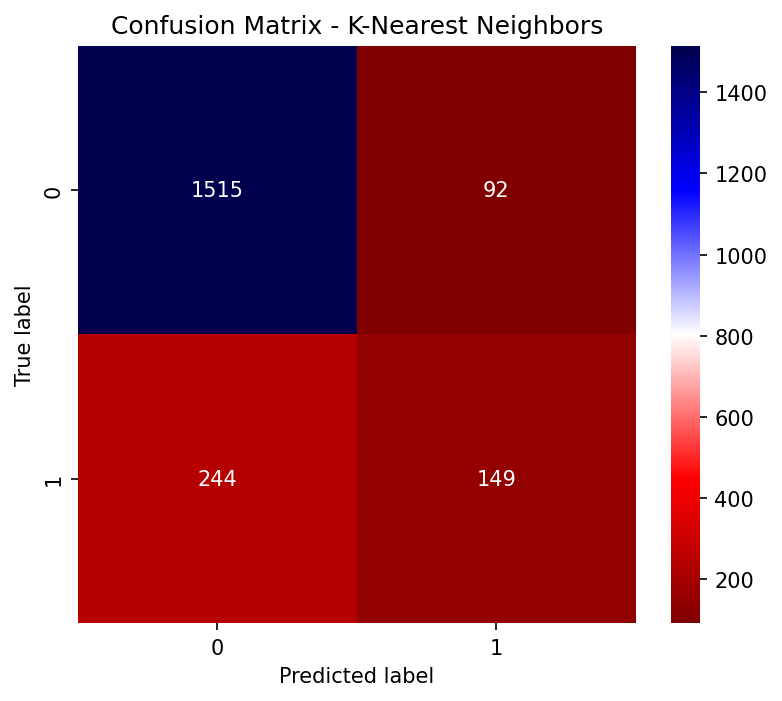

In [11]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 5), dpi = 150)
sns.heatmap(cm, annot = True, fmt = "g", cmap = "seismic_r")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.show()

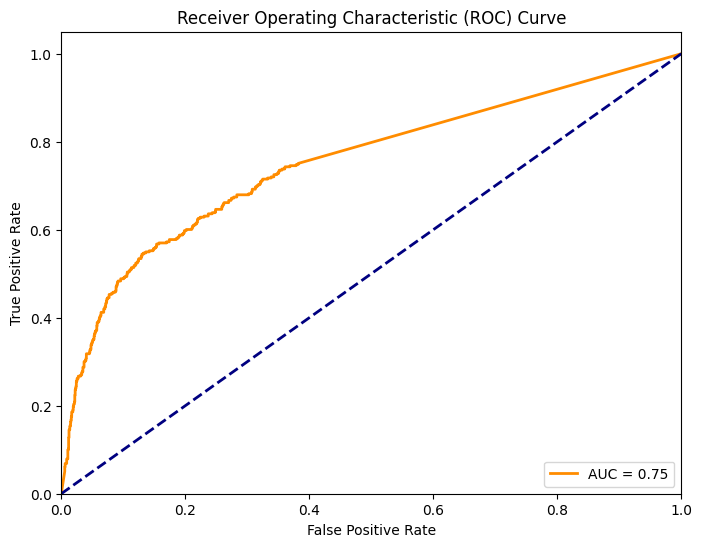

In [12]:
# Predict probabilities on the test set
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc = "lower right")
plt.show()

In [13]:
# With cross-validation for threshold tuning ON TRAINING SET ONLY TO AVOID OVERFITTING
classifier_tuned = TunedThresholdClassifierCV(best_model, scoring = "balanced_accuracy").fit(X_train_scaled, y_train)
print(f"Optimal Cut-off point for validation set found at {classifier_tuned.best_threshold_:.3f}")

Optimal Cut-off point for validation set found at 0.222


              precision    recall  f1-score   support

           0       0.91      0.66      0.76      1607
           1       0.34      0.72      0.46       393

    accuracy                           0.67      2000
   macro avg       0.62      0.69      0.61      2000
weighted avg       0.80      0.67      0.70      2000



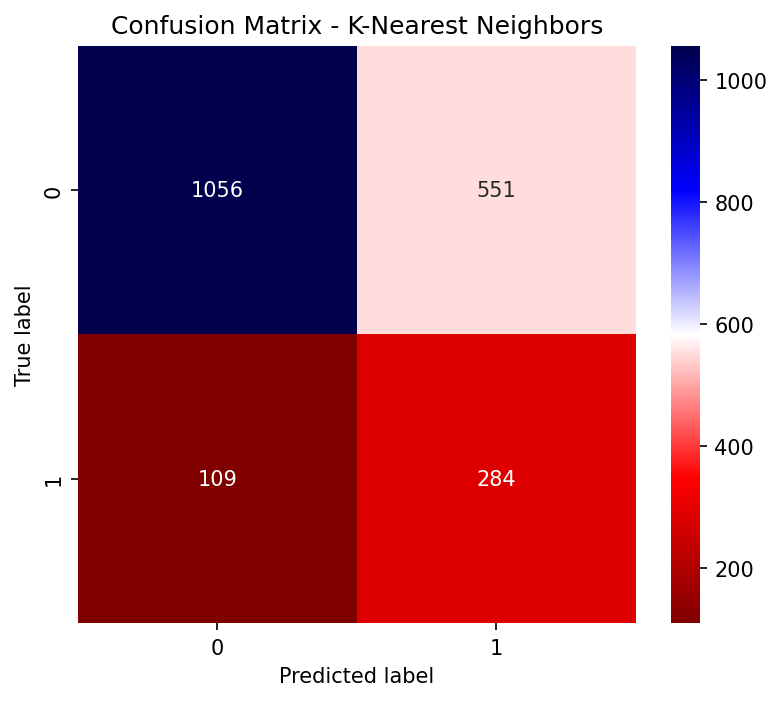

In [14]:
# Get predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
# y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Adjust the threshold based on tuned classifier
threshold = classifier_tuned.best_threshold_
y_pred = (y_probs >= threshold).astype(int)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 5), dpi = 150)
sns.heatmap(cm, annot = True, fmt = "g", cmap = "seismic_r")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.show()

### Define model parameters for `GridSearchCV` to find optimal algorithms for `KNeighborsClassifier`, `LogisticRegression`, `RandomForestClassifier` and `XGBClassifier`

In [15]:
# Choose a randoim number to set the random state for reproducible results
state_num = 42

# Define model parameters as nested dictionary
model_params = {
    "K Nearest Neighbors Classifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": np.arange(2, 11, 1),
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(solver = "saga", penalty = "elasticnet", random_state = state_num, max_iter = 1000),
        "params": {
            "C": [0.1, 1.0],
            "l1_ratio": np.arange(0, 1.1, 0.1)
        }
    },
    "Random Forest Classifier": {
        "model": RandomForestClassifier(random_state = state_num, n_jobs = -1),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, 30],
            "min_samples_leaf": [1, 2, 4, 8],
            "min_samples_split": [2, 5, 10]
        }
    },
    "XGBoost Classifier": {
        "model": XGBClassifier(scale_pos_weight = 4, random_state = state_num, n_jobs = -1),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 4, 5],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    }
}

### Create a function `evaluate_best_model()` to view the classification report, confusion matrix, ROC AUC score at initial threshold of 0.5, classification report and confusion matrix at cross-validated training set optimal threshold, plus store the best models in a dataframe 

In [16]:
def evaluate_best_model(param_grid, cm_palette):
    # Store final results
    scores = []

    # Loop to find the optimal algorithm for each machine learning algorithm
    for model_name, mp in param_grid.items():
        clf = GridSearchCV(
            estimator = mp["model"], 
            param_grid = mp["params"], 
            scoring = {
                "roc_auc_score": make_scorer(roc_auc_score),
                "accuracy": make_scorer(accuracy_score), 
                "f1_score": make_scorer(f1_score)
            },
            cv = 5, 
            return_train_score = False,
            refit = "roc_auc_score", # Can refit to select which scoring metric is most important (will be used to obtain best_estimator_)
            n_jobs = -1
        )
        clf.fit(X_train_scaled, y_train)

        print(f"For {model_name}:")

        # Get best estimator based on highest ROC AUC score (refit parameter in GridSearchCV)
        best_model = clf.best_estimator_
        print(f"Best model (Highest ROC AUC Score): {best_model}")

        # Obtain average amount of time for fitting the training data using this model
        mean_fit_time = clf.cv_results_["mean_fit_time"][clf.best_index_]

        # Predict discrete values and probabilities on the test set
        y_pred = best_model.predict(X_test_scaled)
        y_prob = best_model.predict_proba(X_test_scaled)[:, 1] # Need for AUC

        test_roc_auc, test_f1_score, test_acc_score = roc_auc_score(y_test, y_prob), f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

        print(f"Test ROC AUC Score: {round(test_roc_auc, 4)}")
        print(f"Test F1 Score: {round(test_f1_score, 4)}")
        print(f"Test Accuracy Score: {round(test_acc_score, 4)}")

        # Get classification report results
        print(classification_report(y_test, y_pred))

        # Visualise confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize = (6, 5), dpi = 150)
        sns.heatmap(cm, annot = True, fmt = "g", cmap = cm_palette)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

        # Calculate the ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr) # Should be same value as ROC AUC score

        # Plot the ROC curve
        plt.figure(figsize = (8, 6))
        plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Receiver Operating Characteristic (ROC) Curve for {model_name}")
        plt.legend(loc = "lower right")
        plt.show()

        # With cross-validation for threshold tuning (only on training set to avoid overfitting)
        classifier_tuned = TunedThresholdClassifierCV(best_model, scoring = "balanced_accuracy").fit(X_train_scaled, y_train)
        print(f"Optimal Cut-off threshold point for validation set found at {classifier_tuned.best_threshold_:.3f}")

        # Get predicted probabilities for the positive class
        y_probs = best_model.predict_proba(X_test_scaled)[:, 1]

        # Adjust the threshold based on tuned classifier
        threshold = classifier_tuned.best_threshold_
        y_pred = (y_probs >= threshold).astype(int)

        # Evaluate the model with new threshold
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize = (6, 5), dpi = 150)
        sns.heatmap(cm, annot = True, fmt = "g", cmap = cm_palette)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Confusion Matrix - {model_name} (with modified threshold)")
        plt.show()

        # Append best model parameters to list
        scores.append({
            "model_name": model_name,
            "best_algorithm": best_model,
            "params": clf.best_params_,
            "mean_fit_time": mean_fit_time,
            "test_roc_auc_score": test_roc_auc,
            "test_f1_score": test_f1_score,
            "test_acc_score": test_acc_score,
        })

        print("\n")

    # Store best models in dataframe
    score_df = pd.DataFrame(scores, columns = scores[0].keys())
    score_df.set_index("model_name", inplace = True)
    score_df.index.name = None  # Remove the name of the index
    
    return score_df

### Run model on transformed data (Approach 1)

For K Nearest Neighbors Classifier:
Best model (Highest ROC AUC Score): KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
Test ROC AUC Score: 0.7518
Test F1 Score: 0.47
Test Accuracy Score: 0.832
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.62      0.38      0.47       393

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.69      2000
weighted avg       0.81      0.83      0.82      2000



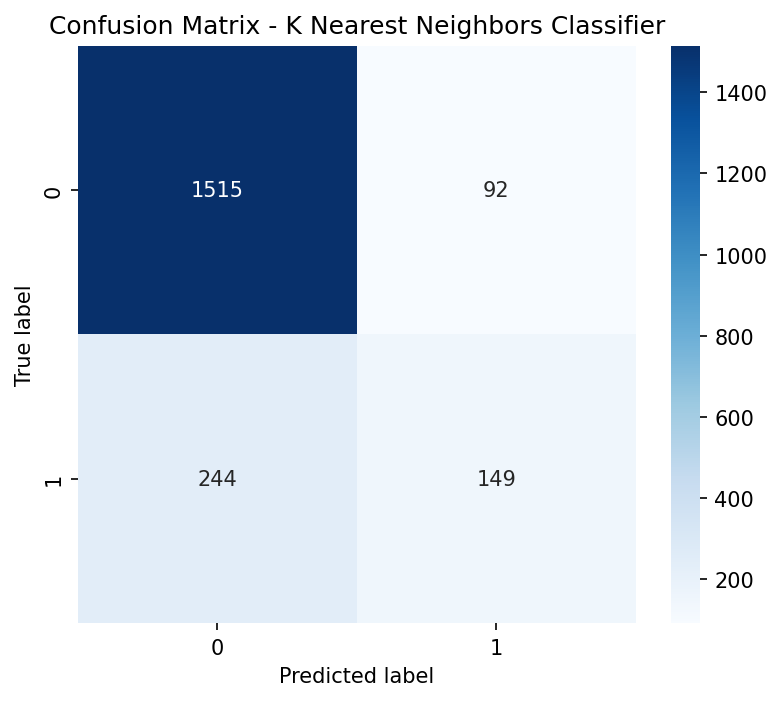

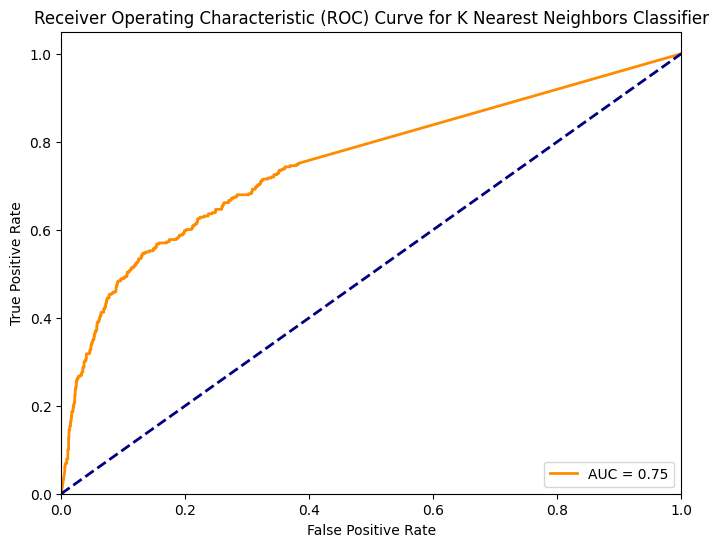

Optimal Cut-off threshold point for validation set found at 0.222
              precision    recall  f1-score   support

           0       0.91      0.66      0.76      1607
           1       0.34      0.72      0.46       393

    accuracy                           0.67      2000
   macro avg       0.62      0.69      0.61      2000
weighted avg       0.80      0.67      0.70      2000



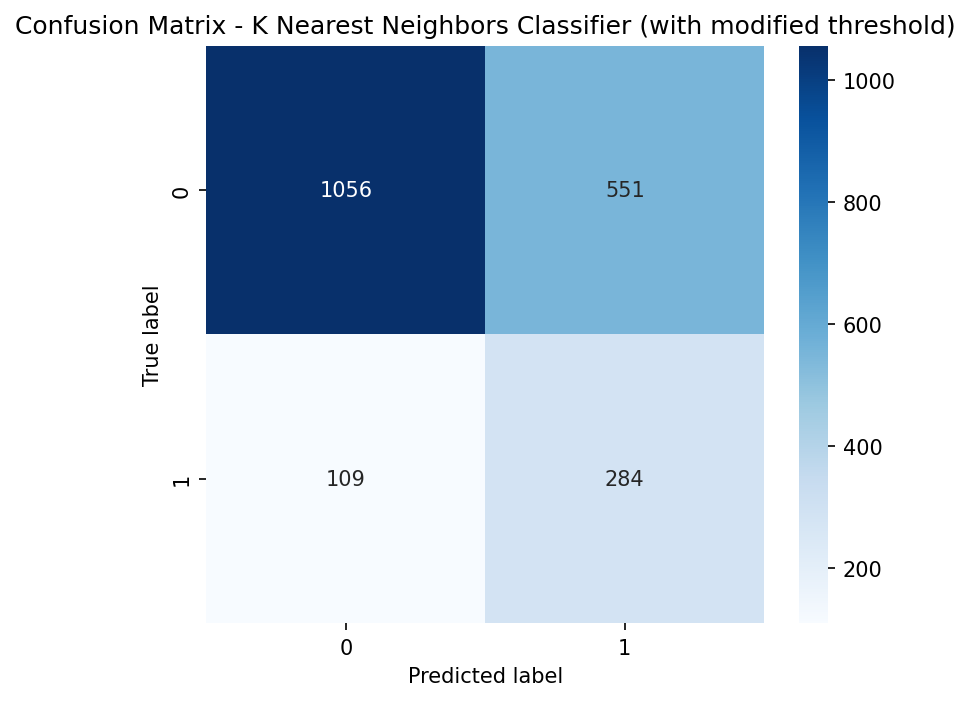



For Logistic Regression:
Best model (Highest ROC AUC Score): LogisticRegression(l1_ratio=0.0, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')
Test ROC AUC Score: 0.8367
Test F1 Score: 0.49
Test Accuracy Score: 0.847
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1607
           1       0.71      0.37      0.49       393

    accuracy                           0.85      2000
   macro avg       0.79      0.67      0.70      2000
weighted avg       0.83      0.85      0.83      2000



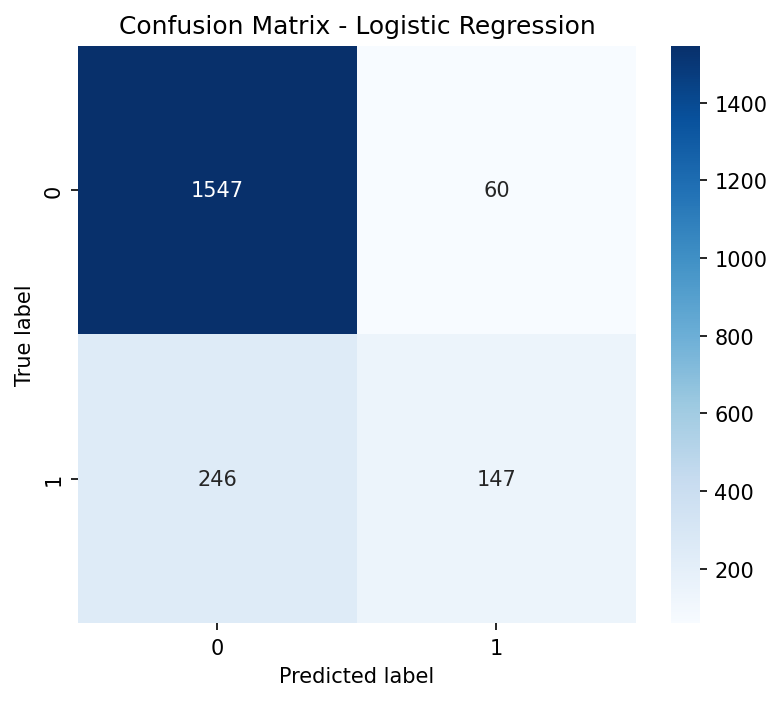

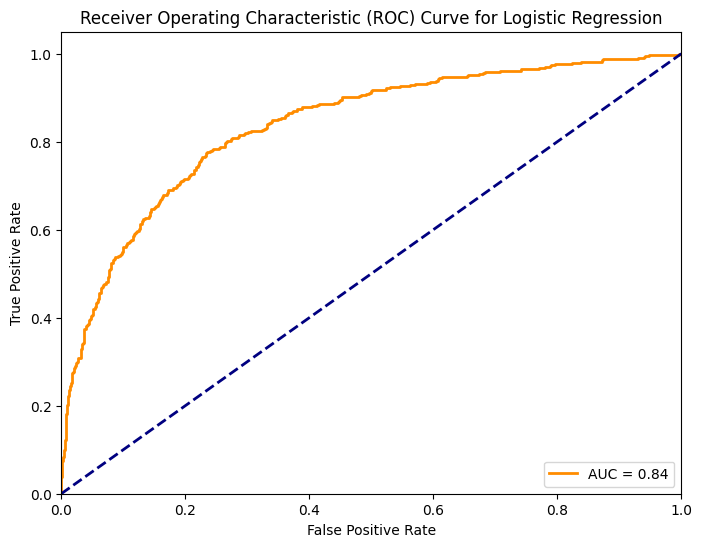

Optimal Cut-off threshold point for validation set found at 0.225
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1607
           1       0.45      0.73      0.56       393

    accuracy                           0.78      2000
   macro avg       0.69      0.76      0.71      2000
weighted avg       0.83      0.78      0.79      2000



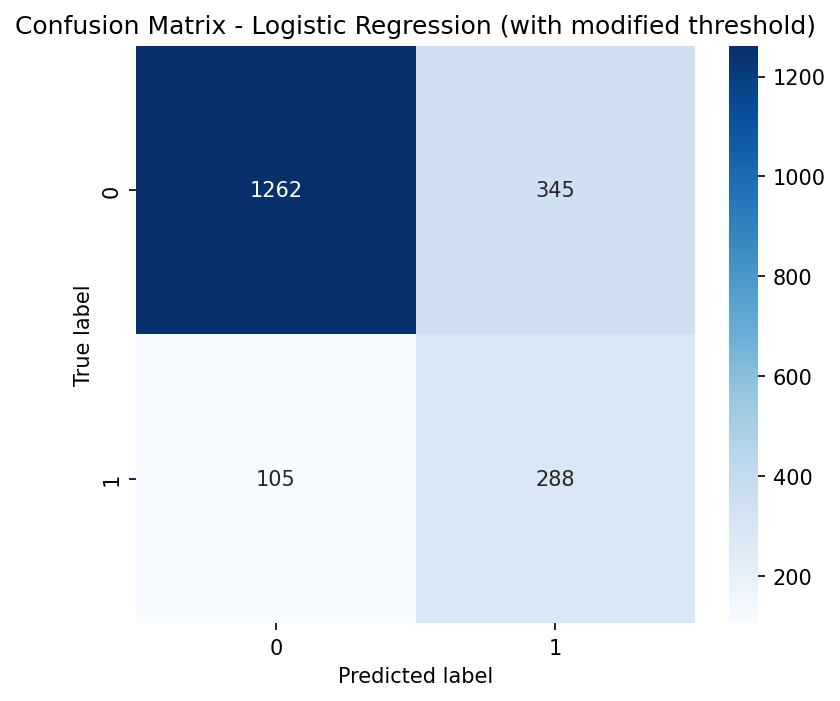



For Random Forest Classifier:
Best model (Highest ROC AUC Score): RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=300,
                       n_jobs=-1, random_state=42)
Test ROC AUC Score: 0.8653
Test F1 Score: 0.5893
Test Accuracy Score: 0.869
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.77      0.48      0.59       393

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.86      2000



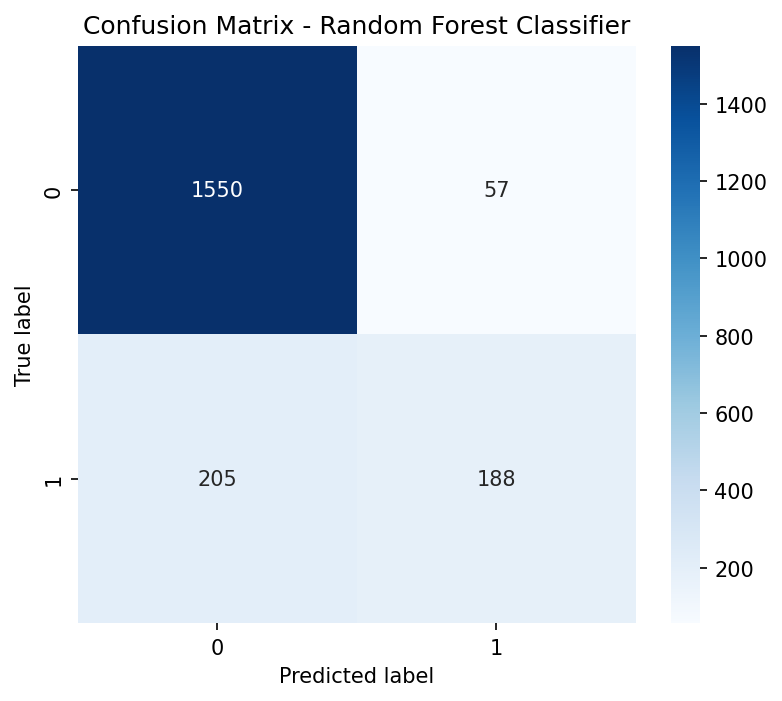

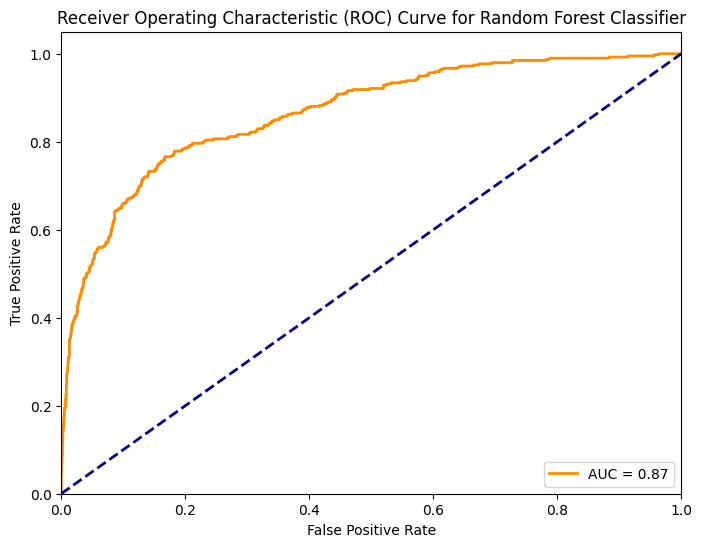

Optimal Cut-off threshold point for validation set found at 0.234
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      1607
           1       0.49      0.78      0.60       393

    accuracy                           0.80      2000
   macro avg       0.72      0.79      0.73      2000
weighted avg       0.85      0.80      0.81      2000



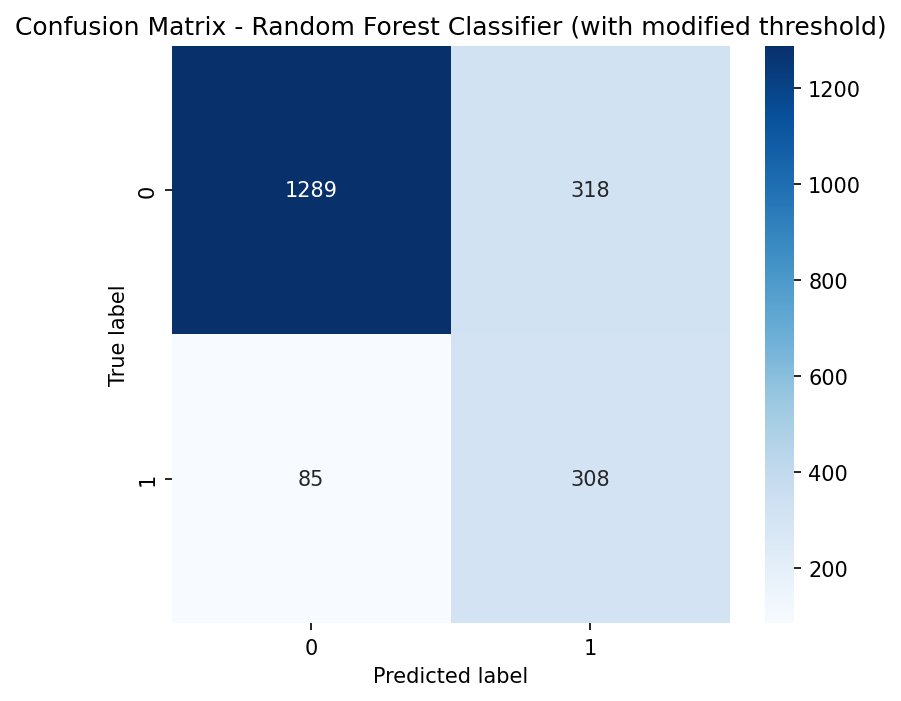



For XGBoost Classifier:
Best model (Highest ROC AUC Score): XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)
Test ROC AUC Score: 0.8718
Test F1 Score: 0.6172
Test Accuracy Score: 0.8065
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1607
   

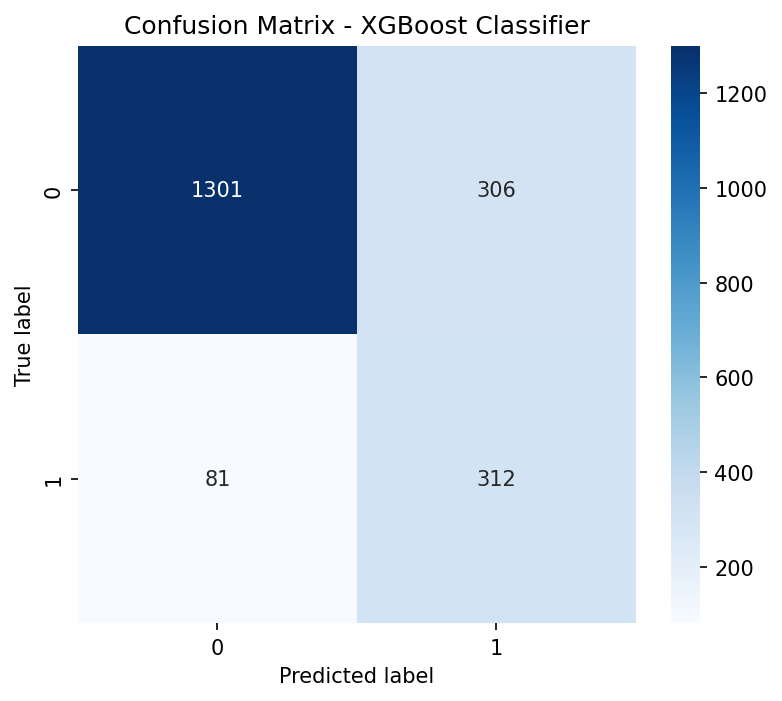

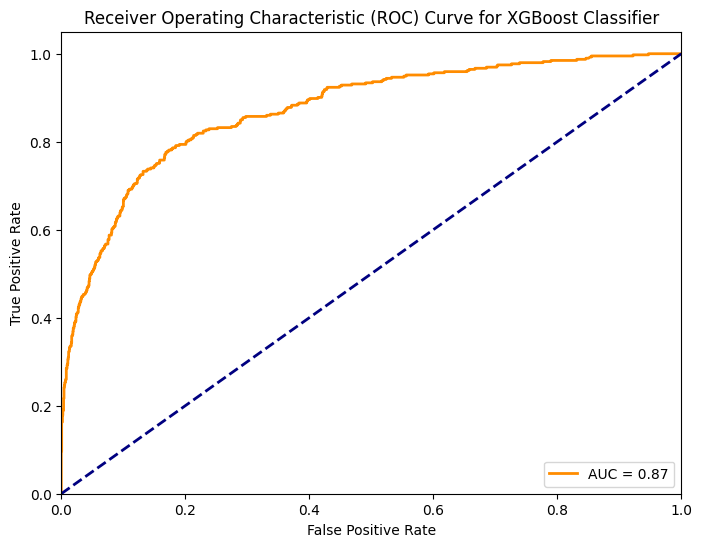

Optimal Cut-off threshold point for validation set found at 0.515
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1607
           1       0.52      0.78      0.62       393

    accuracy                           0.81      2000
   macro avg       0.73      0.80      0.75      2000
weighted avg       0.86      0.81      0.83      2000



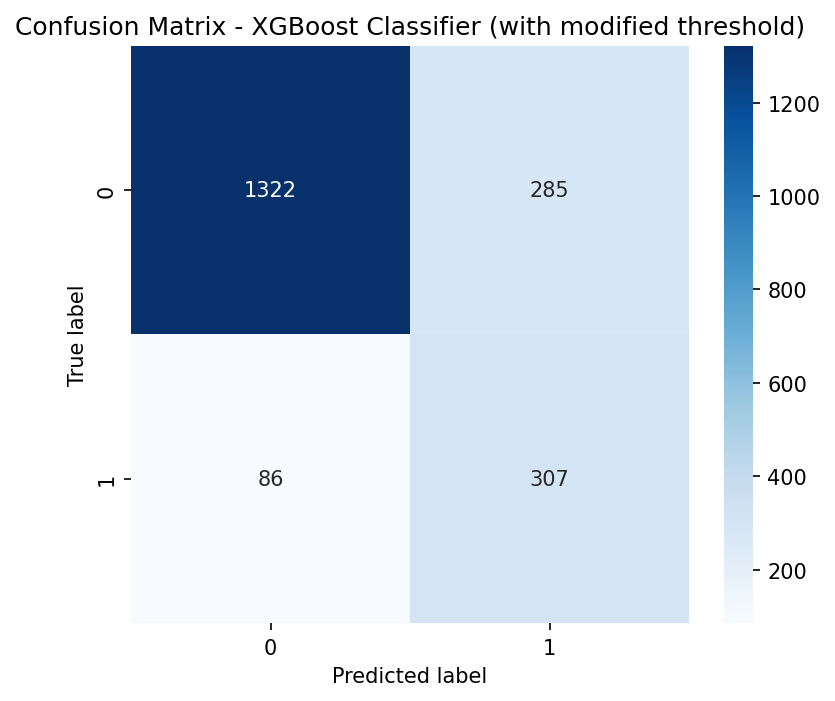

In [17]:
score_df_age_num = evaluate_best_model(param_grid = model_params, cm_palette = "Blues")

In [18]:
# View stored results
score_df_age_num

,best_algorithm,params,mean_fit_time,test_roc_auc_score,test_f1_score,test_acc_score
K Nearest Neighbors Classifier,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.013315,0.751841,0.470032,0.8320
Logistic Regression,"LogisticRegression(l1_ratio=0.0, max_iter=1000...","{'C': 1.0, 'l1_ratio': 0.0}",0.282205,0.836689,0.490000,0.8470
Random Forest Classifier,"(DecisionTreeClassifier(max_depth=30, max_feat...","{'max_depth': 30, 'min_samples_leaf': 1, 'min_...",8.904081,0.865270,0.589342,0.8690
XGBoost Classifier,"XGBClassifier(base_score=None, booster=None, c...","{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.457913,0.871815,0.617211,0.8065


## Sensitivity Analysis for Approach 1

### Permutation Importance Plot for `KNeighborsClassifier`

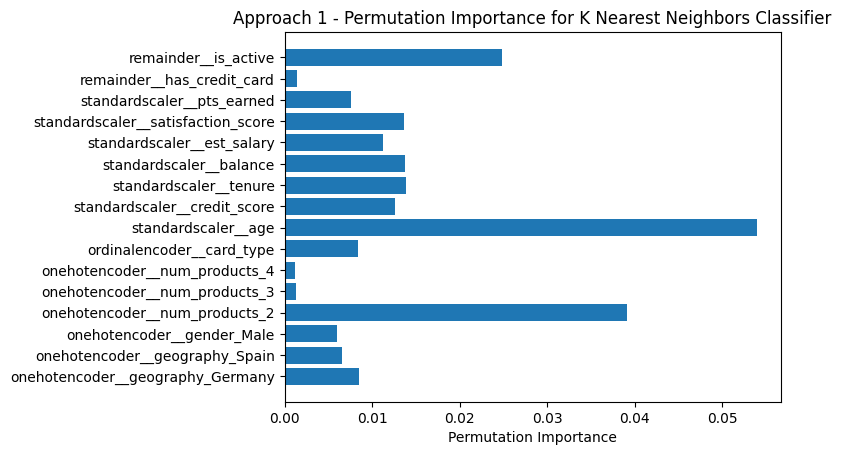

In [19]:
# Fit the KNN Classifier model
model = score_df_age_num.loc["K Nearest Neighbors Classifier"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Calculate permutation importance
perm_model = permutation_importance(model, X_test_scaled, y_test, n_repeats = 10, random_state = 42)

# Plot the importance of features
plt.barh(range(len(perm_model.importances_mean)), perm_model.importances_mean)
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel("Permutation Importance")
plt.title("Approach 1 - Permutation Importance for K Nearest Neighbors Classifier")
plt.show()

### Feature Importance Plot for `RandomForestClassifier` and `XGBoostClassifier`

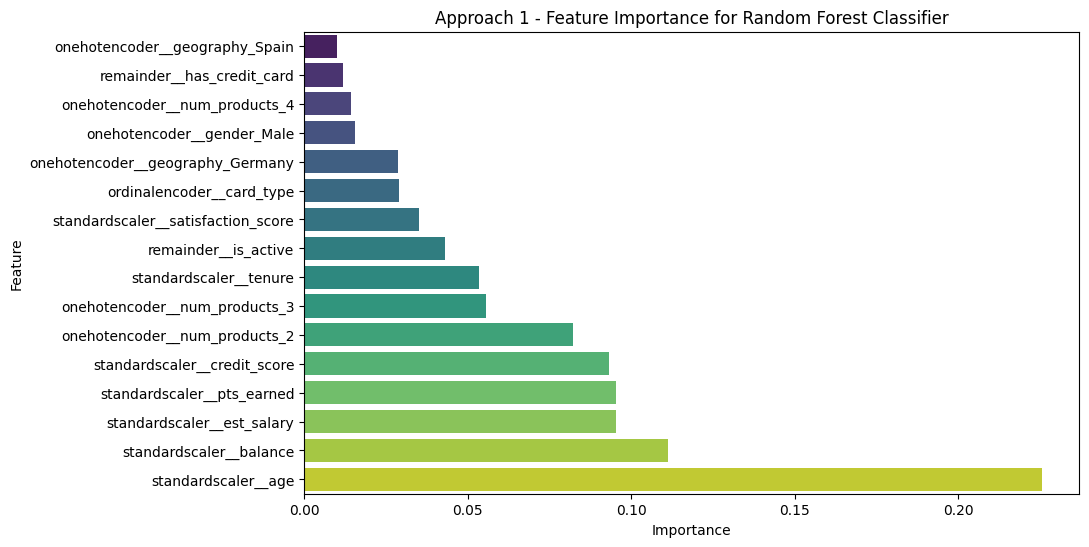

In [20]:
# Feature importance plot for Random Forest Classifier
model = score_df_age_num.loc["Random Forest Classifier"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Get feature importances
importances = model.feature_importances_

# Sort the feature importances in descending order
indices = importances.argsort()

# Plot feature importances
plt.figure(figsize = (10, 6))
sns.barplot(x = importances[indices], y = X_train_scaled.columns[indices], palette = "viridis")
plt.title("Approach 1 - Feature Importance for Random Forest Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

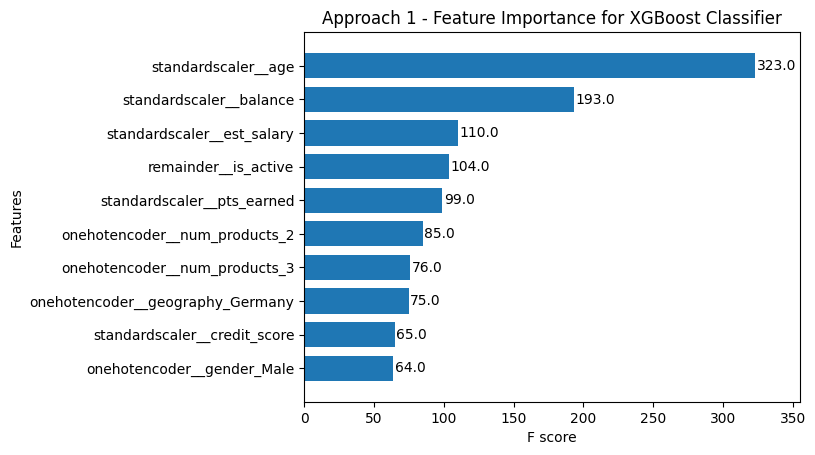

In [21]:
# Feature importance plot for XGBoost Classifier
model = score_df_age_num.loc["XGBoost Classifier"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Plot feature importance
ax = plot_importance(model, importance_type = "weight", max_num_features = 10, height = 0.75)
ax.grid(False)
plt.title("Approach 1 - Feature Importance for XGBoost Classifier")
plt.show()

### Beeswarm Plot to visualise SHAP values for `LogisticRegression` and `XGBoostClassifier`

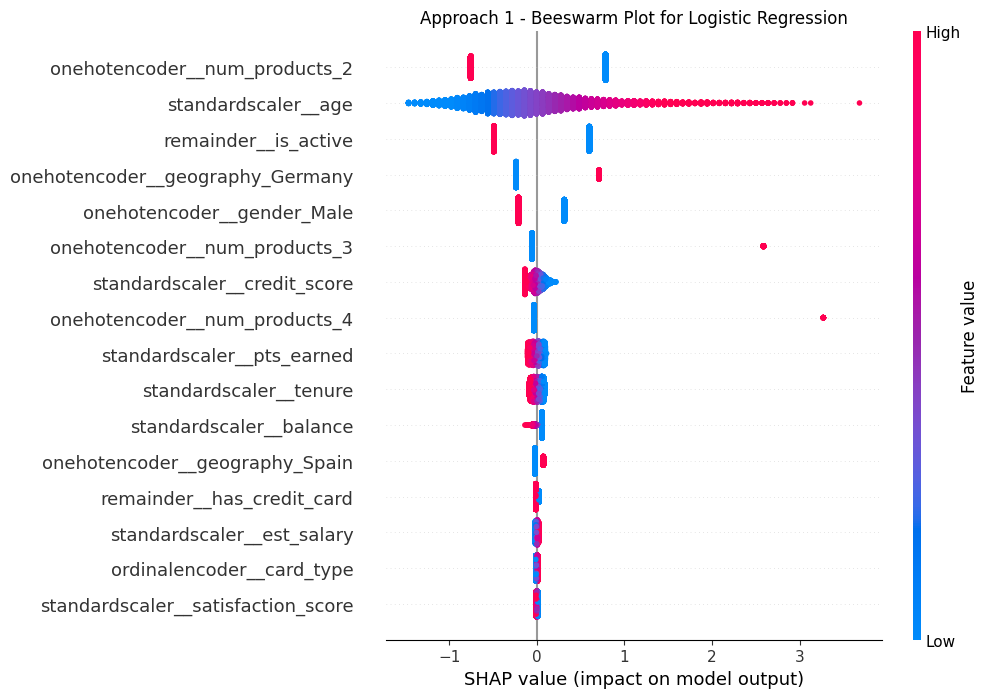

In [22]:
# Fit model on Logistic Regression
model = score_df_age_num.loc["Logistic Regression"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Get SHAP values
explainer = shap.LinearExplainer(model, X_train_scaled)
shap_values = explainer(X_train_scaled)

shap.plots.beeswarm(shap_values, max_display = None, show = False)

plt.title("Approach 1 - Beeswarm Plot for Logistic Regression")
plt.show()

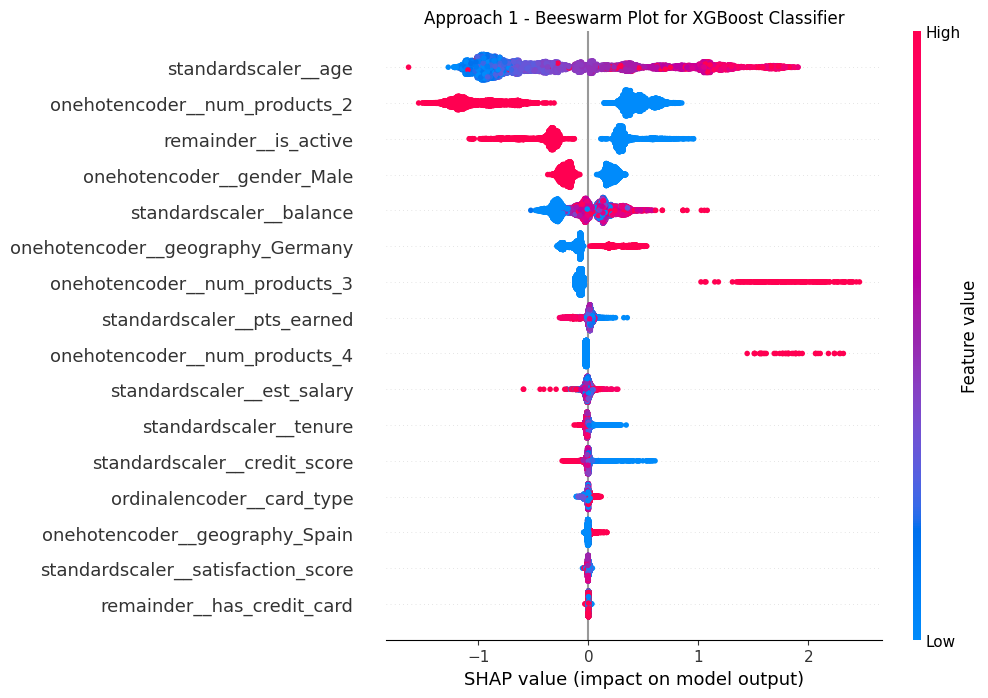

In [23]:
# Fit model on XGBoost Classifier
model = score_df_age_num.loc["XGBoost Classifier"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_train_scaled)

shap.plots.beeswarm(shap_values, max_display = None, show = False)

plt.title("Approach 1 - Beeswarm Plot for XGBoost Classifier")
plt.show()

## Approach 2: Only use `age_group` as a categorical variable

In [24]:
# 2. Choose to use age group as a categorical age group and drop the numeric variable 
df2 = df.drop("age", axis = 1)
df2.head()

,geography,gender,has_credit_card,is_active,card_type,age_group,credit_score,tenure,balance,num_products,est_salary,satisfaction_score,pts_earned,churned
0,France,Female,1,1,DIAMOND,Middle-Aged (26-45),619,2,0.00,1,101348.88,2,464,1
1,Spain,Female,0,1,DIAMOND,Middle-Aged (26-45),608,1,83807.86,1,112542.58,3,456,0
2,France,Female,1,0,DIAMOND,Middle-Aged (26-45),502,8,159660.80,3,113931.57,3,377,1
3,France,Female,0,0,GOLD,Middle-Aged (26-45),699,1,0.00,2,93826.63,5,350,0
4,Spain,Female,1,1,GOLD,Middle-Aged (26-45),850,2,125510.82,1,79084.10,5,425,0


### Transform and fit data to model

In [25]:
# Define target column "churned"
y = df2["churned"]

# Define feature matrix X (all columns except "churned")
X = df2.drop(columns = ["churned"])

# Call train-test split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Define the categorical columns to one-hot encode
one_hot_encoded_cols = ["geography", "gender", "age_group", "num_products"]
ord_encoded_cols = ["card_type"]

# Define the numeric columns to scale
numeric_cols = ["credit_score", "tenure", "balance", "est_salary", "satisfaction_score", "pts_earned"]

# Create a column transformer to handle both the encoding and scaling
ct = make_column_transformer(
    (OneHotEncoder(drop = "first", sparse_output = False), one_hot_encoded_cols), # One-hot encoded categorical columns
    (OrdinalEncoder(categories = [["SILVER", "GOLD", "PLATINUM", "DIAMOND"]]), ord_encoded_cols),  # Ordinal encoded categorical columns
    (StandardScaler(), numeric_cols), # Scale numeric columns
    remainder = "passthrough" # Keep columns not transformed (e.g., "has_credit_card" and "is_active")
)

# Change output to pandas dataframe for easier readability
ct.set_output(transform = "pandas")

# Fit the column transformer on the training data and transform it
X_train_scaled = ct.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = ct.transform(X_test)

In [26]:
X_train_scaled

,onehotencoder__geography_Germany,onehotencoder__geography_Spain,onehotencoder__gender_Male,onehotencoder__age_group_Older Adults (46-64),onehotencoder__age_group_Retirement Aged (65+),onehotencoder__age_group_Young Adults (18-25),onehotencoder__num_products_2,onehotencoder__num_products_3,onehotencoder__num_products_4,ordinalencoder__card_type,standardscaler__credit_score,standardscaler__tenure,standardscaler__balance,standardscaler__est_salary,standardscaler__satisfaction_score,standardscaler__pts_earned,remainder__has_credit_card,remainder__is_active
9254,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.356500,0.345680,-1.218471,1.367670,-0.720010,-0.430193,1,1
1561,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,-0.203898,-0.348369,0.696838,1.661254,0.704342,1.565908,1,1
1670,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.961472,-0.695393,0.618629,-0.252807,0.704342,-1.243749,1,0
6087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.940717,1.386753,0.953212,0.915393,-0.720010,-0.176791,1,0
6669,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.397337,1.386753,1.057449,-1.059600,-0.007834,0.534515,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.207474,1.039728,-0.102301,-0.539860,-0.007834,-0.167899,1,1
5191,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.314989,-1.389442,-1.218471,-1.733882,0.704342,0.454493,1,1
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.865009,-1.389442,-1.218471,-0.142765,1.416518,0.316678,0,0
860,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.159323,1.039728,1.827259,-0.050826,-0.007834,0.325569,1,0


In [27]:
X_test_scaled

,onehotencoder__geography_Germany,onehotencoder__geography_Spain,onehotencoder__gender_Male,onehotencoder__age_group_Older Adults (46-64),onehotencoder__age_group_Retirement Aged (65+),onehotencoder__age_group_Young Adults (18-25),onehotencoder__num_products_2,onehotencoder__num_products_3,onehotencoder__num_products_4,ordinalencoder__card_type,standardscaler__credit_score,standardscaler__tenure,standardscaler__balance,standardscaler__est_salary,standardscaler__satisfaction_score,standardscaler__pts_earned,remainder__has_credit_card,remainder__is_active
6252,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.577496,-0.695393,0.329937,-1.019605,-1.432186,0.454493,0,0
4684,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.297297,-1.389442,-1.218471,0.798883,-0.720010,-0.439084,1,1
1731,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.525607,-0.348369,-1.218471,-0.727980,-1.432186,-1.448249,1,0
4742,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.511492,1.039728,0.689272,1.221387,-0.720010,1.654821,1,1
4521,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.951094,0.692704,0.782839,0.247560,1.416518,-0.665813,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6412,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.515230,-0.001345,0.354911,-0.963100,1.416518,0.916842,0,1
8285,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.442586,1.733777,-1.218471,0.164545,-0.720010,0.201091,0,1
7853,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.813120,0.692704,-1.218471,-1.165916,-0.720010,-0.456867,1,0
1095,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.418766,-0.348369,-1.218471,-0.411635,-0.007834,0.352243,1,0


In [28]:
y_train

9254    0
1561    0
1670    1
6087    1
6669    1
       ..
5734    0
5191    0
5390    1
860     1
7270    0
Name: churned, Length: 8000, dtype: int64

In [29]:
y_test

6252    0
4684    0
1731    0
4742    0
4521    0
       ..
6412    1
8285    0
7853    1
1095    1
6929    1
Name: churned, Length: 2000, dtype: int64

### Run model on transformed data (Approach 2)

For K Nearest Neighbors Classifier:
Best model (Highest ROC AUC Score): KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
Test ROC AUC Score: 0.7236
Test F1 Score: 0.4108
Test Accuracy Score: 0.815
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1607
           1       0.55      0.33      0.41       393

    accuracy                           0.81      2000
   macro avg       0.70      0.63      0.65      2000
weighted avg       0.79      0.81      0.80      2000



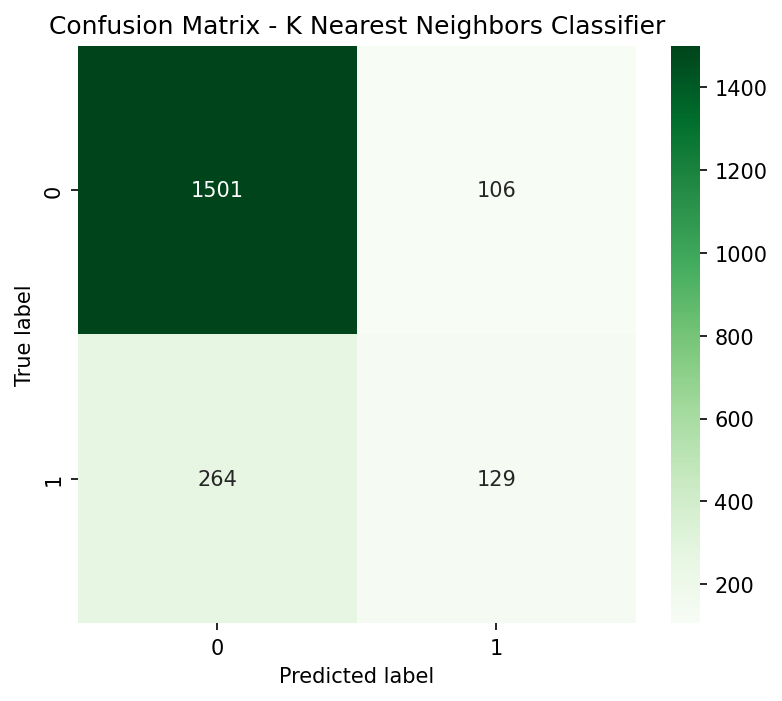

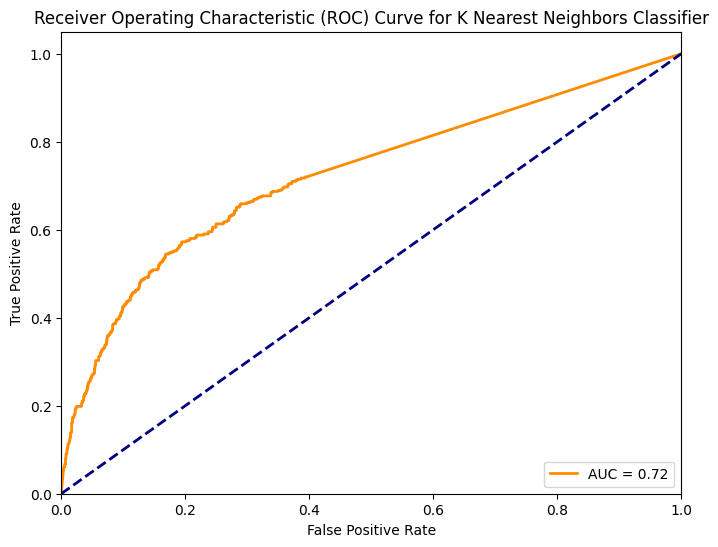

Optimal Cut-off threshold point for validation set found at 0.212
              precision    recall  f1-score   support

           0       0.90      0.63      0.74      1607
           1       0.32      0.70      0.44       393

    accuracy                           0.65      2000
   macro avg       0.61      0.67      0.59      2000
weighted avg       0.78      0.65      0.68      2000



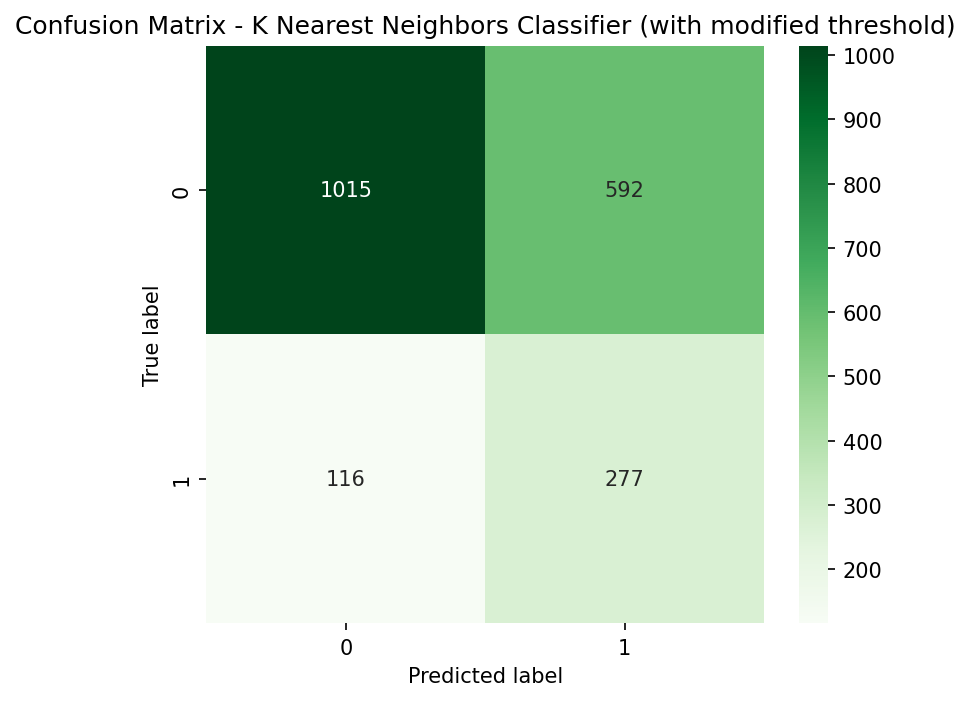



For Logistic Regression:
Best model (Highest ROC AUC Score): LogisticRegression(l1_ratio=1.0, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')
Test ROC AUC Score: 0.836
Test F1 Score: 0.5191
Test Accuracy Score: 0.849
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1607
           1       0.69      0.41      0.52       393

    accuracy                           0.85      2000
   macro avg       0.78      0.68      0.71      2000
weighted avg       0.84      0.85      0.83      2000



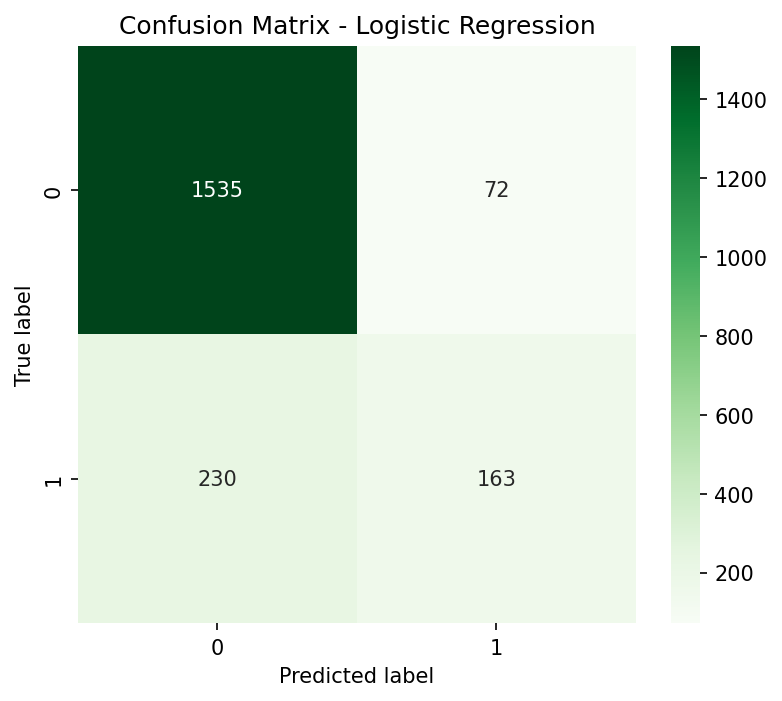

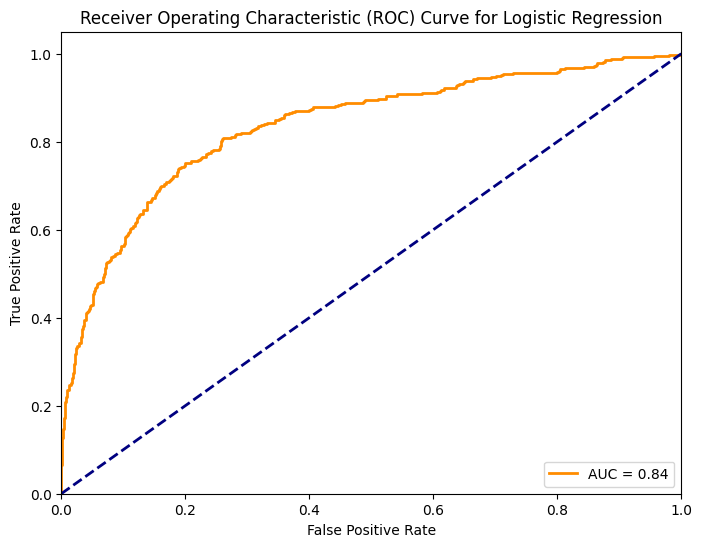

Optimal Cut-off threshold point for validation set found at 0.207
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1607
           1       0.48      0.75      0.58       393

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.84      0.79      0.80      2000



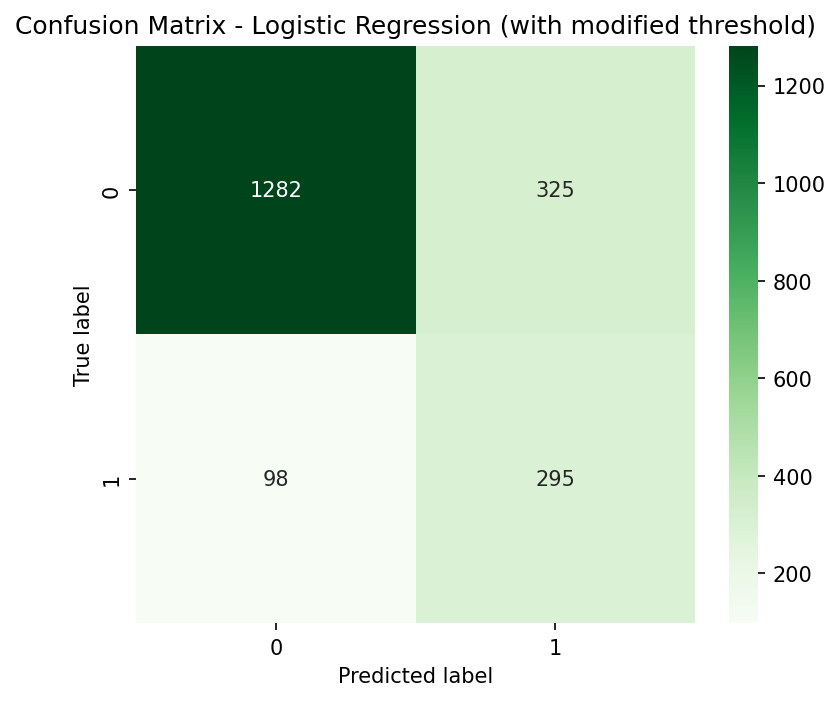



For Random Forest Classifier:
Best model (Highest ROC AUC Score): RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)
Test ROC AUC Score: 0.8361
Test F1 Score: 0.53
Test Accuracy Score: 0.851
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1607
           1       0.70      0.43      0.53       393

    accuracy                           0.85      2000
   macro avg       0.78      0.69      0.72      2000
weighted avg       0.84      0.85      0.84      2000



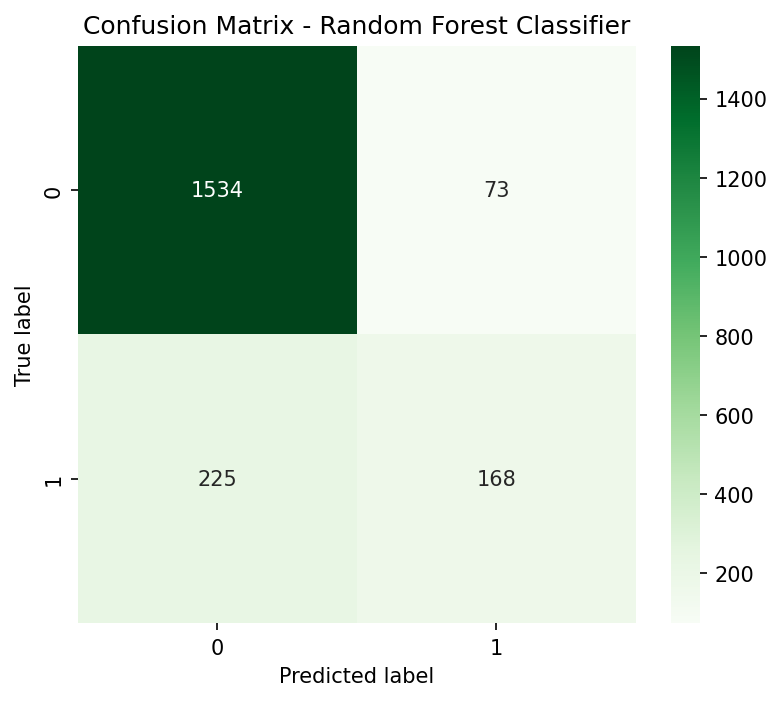

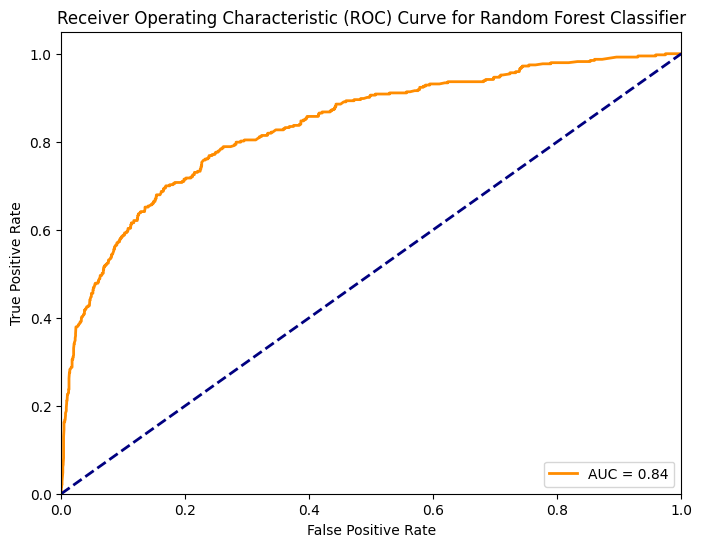

Optimal Cut-off threshold point for validation set found at 0.250
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1607
           1       0.49      0.70      0.58       393

    accuracy                           0.80      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.83      0.80      0.81      2000



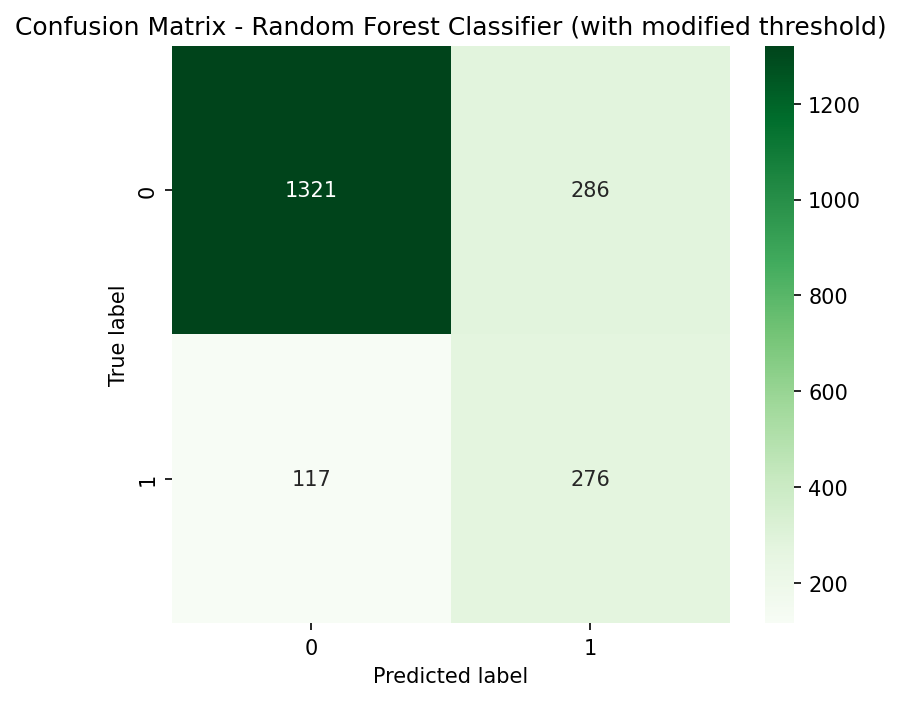



For XGBoost Classifier:
Best model (Highest ROC AUC Score): XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)
Test ROC AUC Score: 0.8511
Test F1 Score: 0.6016
Test Accuracy Score: 0.806
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1607
    

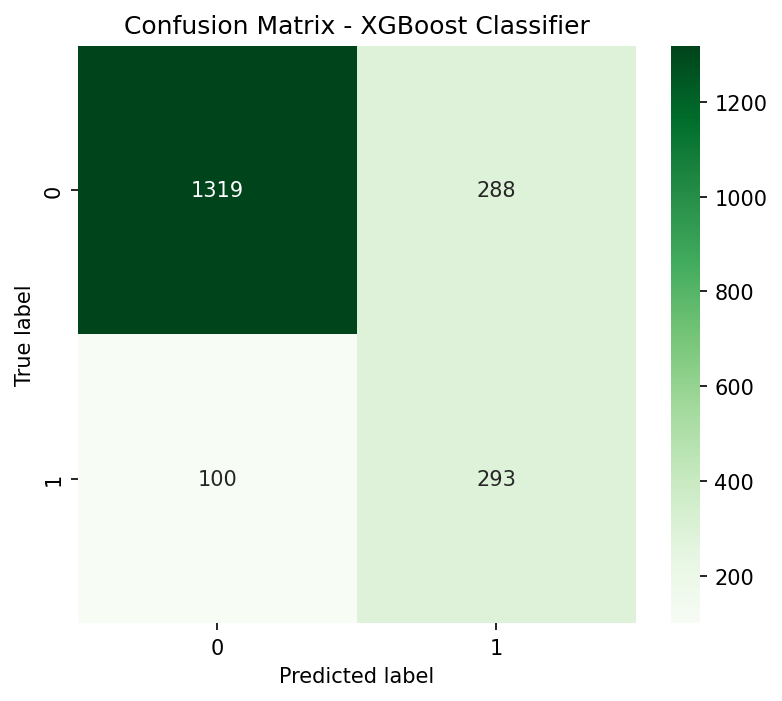

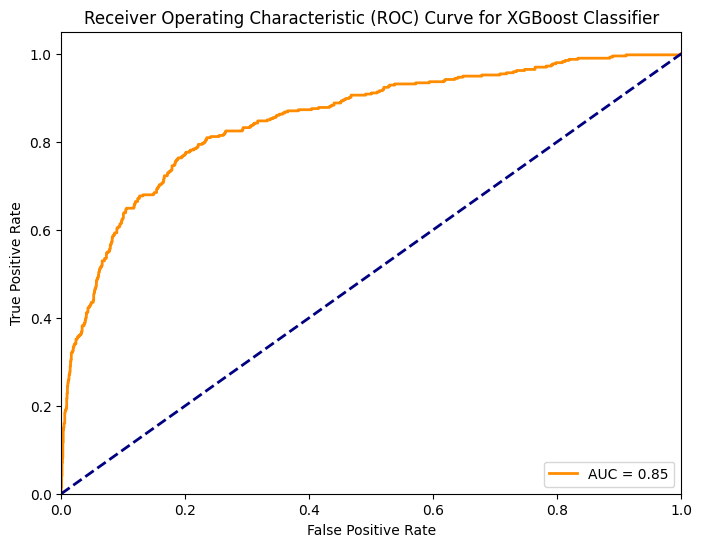

Optimal Cut-off threshold point for validation set found at 0.493
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1607
           1       0.50      0.75      0.60       393

    accuracy                           0.80      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.85      0.80      0.82      2000



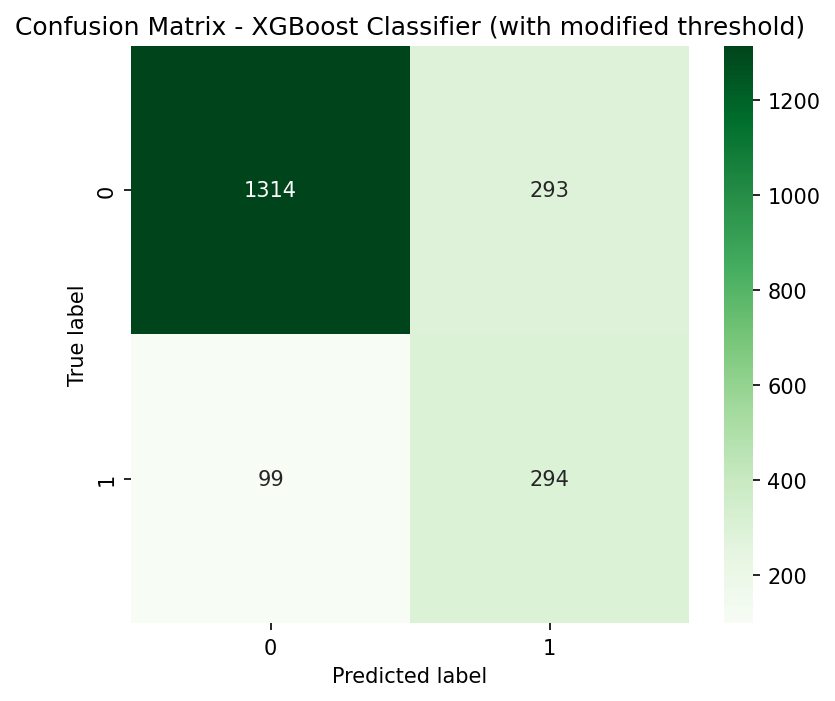

In [30]:
score_df_age_cat = evaluate_best_model(param_grid = model_params, cm_palette = "Greens")

In [31]:
# View stored results
score_df_age_cat

,best_algorithm,params,mean_fit_time,test_roc_auc_score,test_f1_score,test_acc_score
K Nearest Neighbors Classifier,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 4, 'wei...",0.008889,0.723627,0.410828,0.815
Logistic Regression,"LogisticRegression(l1_ratio=1.0, max_iter=1000...","{'C': 1.0, 'l1_ratio': 1.0}",0.579562,0.836013,0.519108,0.849
Random Forest Classifier,"(DecisionTreeClassifier(max_depth=20, max_feat...","{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",3.382932,0.836114,0.529968,0.851
XGBoost Classifier,"XGBClassifier(base_score=None, booster=None, c...","{'colsample_bytree': 1.0, 'learning_rate': 0.0...",2.458547,0.851086,0.601643,0.806


## Sensitivity Analysis for Approach 2

### Permutation Importance Plot for `KNeighborsClassifier`

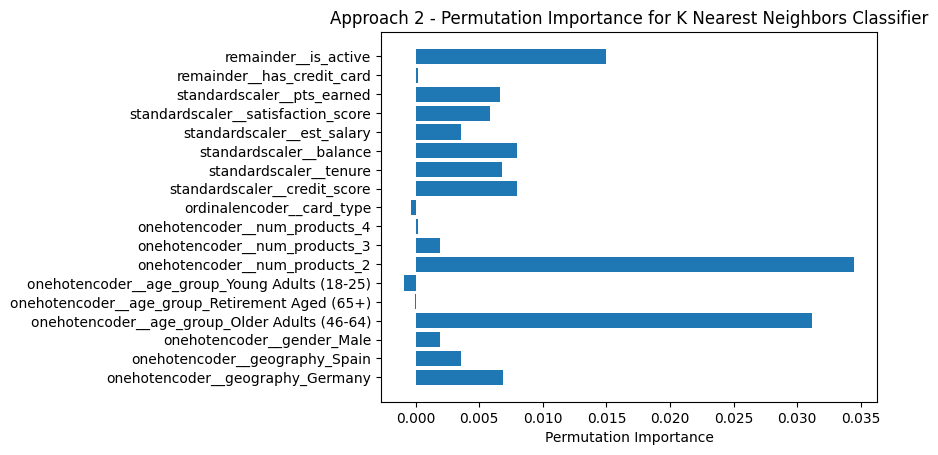

In [32]:
# Fit the KNN Classifier model
model = score_df_age_cat.loc["K Nearest Neighbors Classifier"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Calculate permutation importance
perm_model = permutation_importance(model, X_test_scaled, y_test, n_repeats = 10, random_state = 42)

# Plot the importance of features
plt.barh(range(len(perm_model.importances_mean)), perm_model.importances_mean)
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel("Permutation Importance")
plt.title("Approach 2 - Permutation Importance for K Nearest Neighbors Classifier")
plt.show()

### Feature Importance Plot for `RandomForestClassifier` and `XGBoostClassifier`

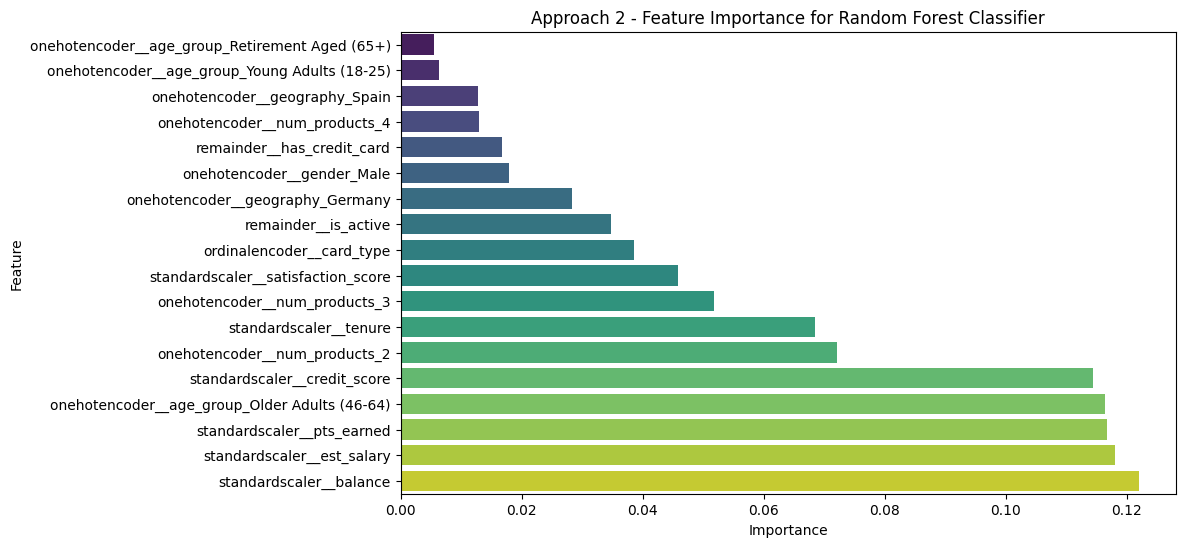

In [33]:
# Feature importance plot for Random Forest Classifier
model = score_df_age_cat.loc["Random Forest Classifier"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Get feature importances
importances = model.feature_importances_

# Sort the feature importances in descending order
indices = importances.argsort()

# Plot feature importances
plt.figure(figsize = (10, 6))
sns.barplot(x = importances[indices], y = X_train_scaled.columns[indices], palette = "viridis")
plt.title("Approach 2 - Feature Importance for Random Forest Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

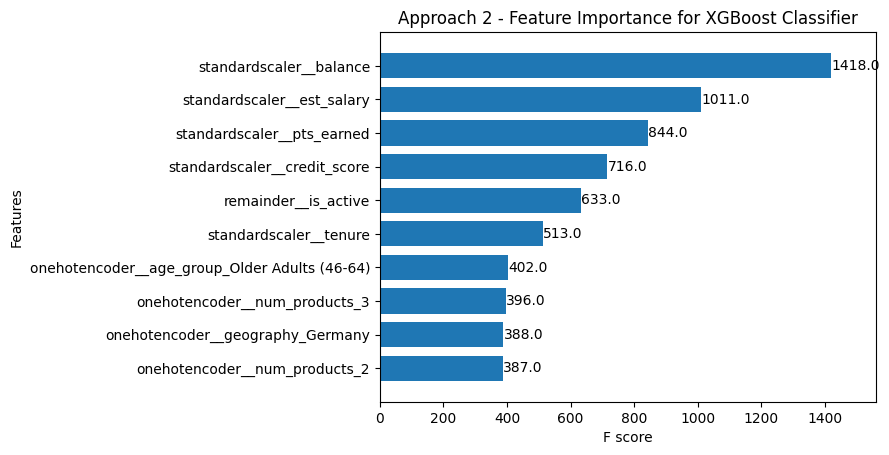

In [34]:
# Feature importance plot for XGBoost Classifier
model = score_df_age_cat.loc["XGBoost Classifier"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Plot feature importance
ax = plot_importance(model, importance_type = "weight", max_num_features = 10, height = 0.75)
ax.grid(False)
plt.title("Approach 2 - Feature Importance for XGBoost Classifier")
plt.show()

### Beeswarm Plot to visualise SHAP values for `LogisticRegression` and `XGBoostClassifier`

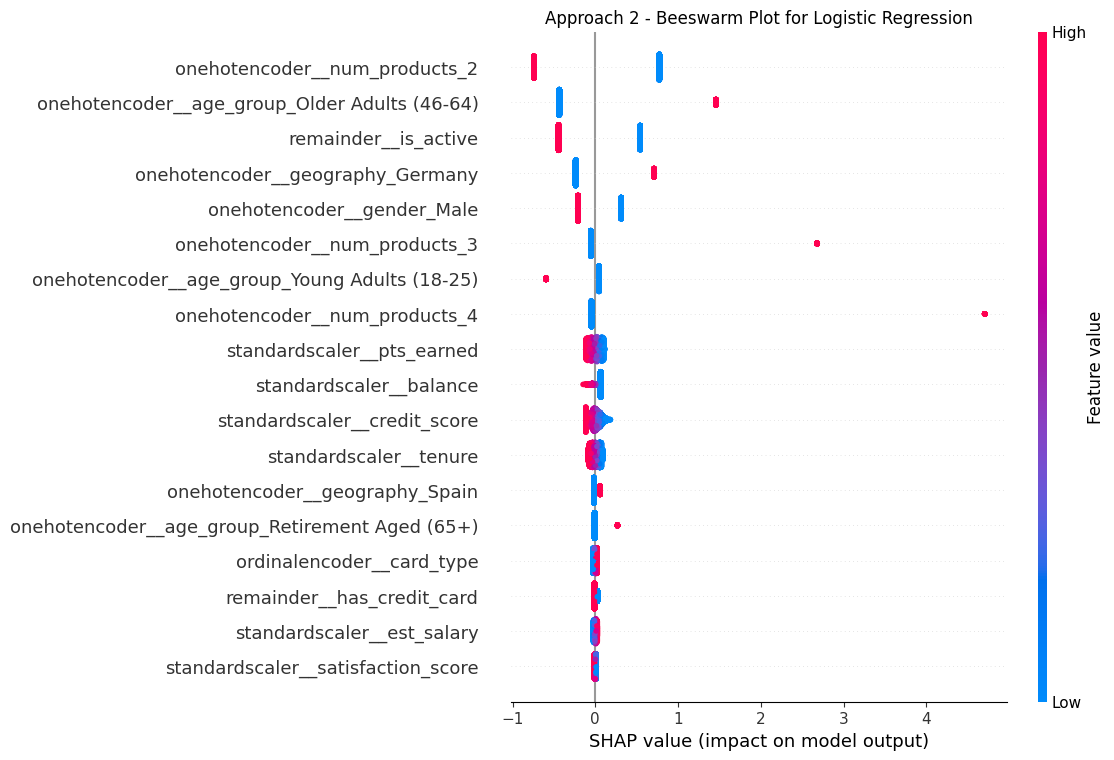

In [35]:
# Fit model on Logistic Regression
model = score_df_age_cat.loc["Logistic Regression"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Get SHAP values
explainer = shap.LinearExplainer(model, X_train_scaled)
shap_values = explainer(X_train_scaled)

shap.plots.beeswarm(shap_values, max_display = None, show = False)

plt.title("Approach 2 - Beeswarm Plot for Logistic Regression")
plt.show()

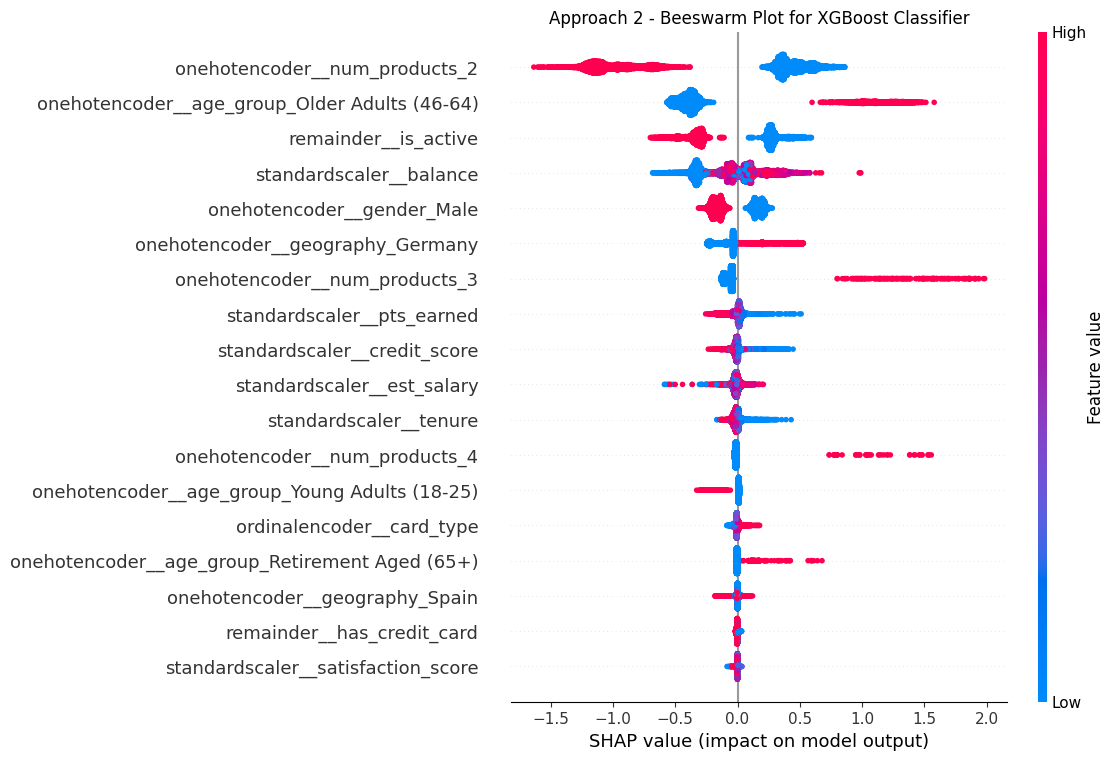

In [36]:
# Fit model on XGBoost Classifier
model = score_df_age_cat.loc["XGBoost Classifier"]["best_algorithm"]
model.fit(X_train_scaled, y_train)

# Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_train_scaled)

shap.plots.beeswarm(shap_values, max_display = None, show = False)

plt.title("Approach 2 - Beeswarm Plot for XGBoost Classifier")
plt.show()

## Final Results

In [37]:
# View stored results
result = pd.concat([score_df_age_num, score_df_age_cat], keys = ["Approach 1", "Approach 2"])
result

best_algorithm  \
Approach 1 K Nearest Neighbors Classifier  KNeighborsClassifier(metric='manhattan', n_nei...   
           Logistic Regression             LogisticRegression(l1_ratio=0.0, max_iter=1000...   
           Random Forest Classifier        (DecisionTreeClassifier(max_depth=30, max_feat...   
           XGBoost Classifier              XGBClassifier(base_score=None, booster=None, c...   
Approach 2 K Nearest Neighbors Classifier  KNeighborsClassifier(metric='manhattan', n_nei...   
           Logistic Regression             LogisticRegression(l1_ratio=1.0, max_iter=1000...   
           Random Forest Classifier        (DecisionTreeClassifier(max_depth=20, max_feat...   
           XGBoost Classifier              XGBClassifier(base_score=None, booster=None, c...   

                                                                                      params  \
Approach 1 K Nearest Neighbors Classifier  {'metric': 'manhattan', 'n_neighbors': 4, 'wei...   
           Logistic Regression                                   {'C': 1.0, 'l1_ratio': 0.0}   
           Random Forest Classifier        {'max_depth': 30, 'min_samples_leaf': 1, 'min_...   
           XGBoost Classifier              {'colsample_bytree': 0.8, 'learning_rate': 0.0...   
Approach 2 K Nearest Neighbors Classifier  {'metric': 'manhattan', 'n_neighbors': 4, 'wei...   
           Logistic Regression                                   {'C': 1.0, 'l1_ratio': 1.0}   
           Random Forest Classifier        {'max_depth': 20, 'min_samples_leaf': 1, 'min_...   
           XGBoost Classifier              {'colsample_bytree': 1.0, 'learning_rate': 0.0...   

                                           mean_fit_time  test_roc_auc_score  \
Approach 1 K Nearest Neighbors Classifier       0.013315            0.751841   
           Logistic Regression                  0.282205            0.836689   
           Random Forest Classifier             8.904081            0.865270   
           XGBoost Classifier                   0.457913            0.871815   
Approach 2 K Nearest Neighbors Classifier       0.008889            0.723627   
           Logistic Regression                  0.579562            0.836013   
           Random Forest Classifier             3.382932            0.836114   
           XGBoost Classifier                   2.458547            0.851086   

                                           test_f1_score  test_acc_score  
Approach 1 K Nearest Neighbors Classifier       0.470032          0.8320  
           Logistic Regression                  0.490000          0.8470  
           Random Forest Classifier             0.589342          0.8690  
           XGBoost Classifier                   0.617211          0.8065  
Approach 2 K Nearest Neighbors Classifier       0.410828          0.8150  
           Logistic Regression                  0.519108          0.8490  
           Random Forest Classifier             0.529968          0.8510  
           XGBoost Classifier                   0.601643          0.8060